In [1]:
import torch 
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt


In [3]:
inp = torch.randn(2, 2)
input_shape = inp.shape
net = nn.Sequential(
    #nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2, stride=2),
    nn.Linear(2, 2),
    nn.Linear(2, 1),
)
# xavier initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
net.apply(init_weights)
for layer in net:
    #print(layer)
    # print(type(layer))
    if isinstance(layer, nn.Linear):
        print("Linear layer")

Linear layer
Linear layer


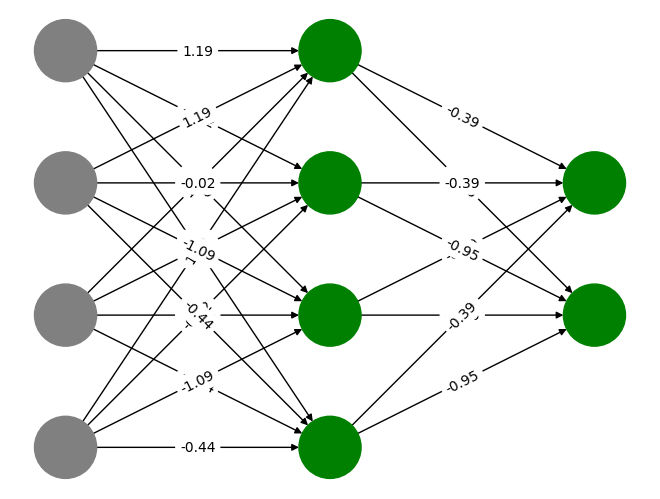

In [4]:
G = nx.DiGraph()

inp_layer = torch.zeros_like(inp)
prev_layer = inp_layer
for i in range(prev_layer.shape[0]):
    for j in range(prev_layer.shape[1]):
        G.add_node(f'0_{i}_{j}')
        G.nodes[f'0_{i}_{j}']['subset_key'] = 0
        
layer_num=1
for i,layer in enumerate(net):
    if isinstance(layer, nn.Linear):
        weight_matrix = layer.weight
        bias = layer.bias
        
        for i in range(weight_matrix.shape[0]):
            for j in range(weight_matrix.shape[1]):
                G.add_node(f'{layer_num}_{i}_{j}')
                G.nodes[f'{layer_num}_{i}_{j}']['subset_key'] = layer_num
                for k in range(prev_layer.shape[0]):
                    for l in range(prev_layer.shape[1]):
                        weight = round(weight_matrix[i][j].item(), 2)
                        G.add_edge(f'{layer_num-1}_{k}_{l}', f'{layer_num}_{i}_{j}', weight=weight)
    layer_num+=1

# Ensure all nodes have a 'subset_key' attribute
for node in G.nodes():
    if 'subset_key' not in G.nodes[node]:
        G.nodes[node]['subset_key'] = 0  # or any default value

# draw input nodes as gray, linear nodes as green
color_map =['gray' if node.startswith('0_') else 'green' for node in G.nodes()]
# use  multipartite_layout to position nodes based on their subset_key. show weights
pos = nx.multipartite_layout(G, subset_key='subset_key')
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=2000, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()